In [7]:
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk import sent_tokenize, word_tokenize
from string import punctuation
import string
from nltk.corpus import stopwords
stop = set(stopwords.words('russian'))
# from nltk.stem import SnowballStemmer
from collections import Counter
# stemmer = SnowballStemmer('russian')
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans


from random import shuffle

## Data Preparation

In [59]:

col_type={'_id': str,
           'cont_num':str,
           'sign_date':str,
           'custom_regnum':str,
           'product_name':str,
           'okdp_code':str,
           'okei_code':str,
           'quantity':float,
           'price':float,
           'sum':float
           }

df = pd.read_csv('datascript/medical_2012.csv', sep=';',dtype=col_type)
df = df.drop(['cont_num', 'sign_date', 'custom_regnum', 'okdp_code', 'okei_code'], axis=1)

df['name_norm']=df['product_name'].map(lambda x: re.sub(r'(\D)\.', r'\1. ',x))  # delete symbol point everywhere except for in numbers
df['name_norm']=df['name_norm'].map(lambda x: x.lower())
df['name_norm']=df['name_norm'].map(lambda x: x.replace('№ ','№')) 
df['name_norm']=df['name_norm'].map(lambda x: re.sub(r' n(\d+)| n (\d+)| no(\d+)| no (\d+)', r' №\1',x)) 

mystoplist=[' для ',' д/', ' и ', ' в ',' с ',' у ', ' на ', ' а ',' не ', ' о ']# need also exclude \\dlya
# stoplist = [' ' + stopword + ' ' for stopword in list(stop)]
# mystoplist += stoplist
my_regex = re.compile('|'.join(mystoplist))
df['name_norm']=df['name_norm'].apply(lambda x: my_regex.sub(' ',x)) 
df['name_norm']=df['name_norm'].apply(lambda x: x.replace(':',' ')) 
#punctuation=''.join([sim for sim in list(punctuation) if sim not in ['%',',']]) # list of simbols not to delete

translator = str.maketrans('','',punctuation) 
df['name_norm']=df['name_norm'].map(lambda x: x.translate(translator))

In [60]:
#return number of drug
def prod_number(doc):
    substr=re.search('№\d+',doc)
    if substr: return str(substr[0])
    return ''

#return type of drug
def prod_type(doc):
    for key, value in type_dict.items():    
        if len([w for w in doc if w in value])>0:
            return key
    return 'unknown' 

#delete stopwords
def del_list(doc,dic):
    text=doc
    for key, value in dic.items():    
        text=[w for w in text if w not in value]
    return text

In [61]:
def convert_float(num):
    return float(num.replace(',', '.'))

In [62]:
def weight_mg(doc):
    substr=re.search('\d+,\d+мг',doc)
    if substr: return convert_float(str(substr[0])[:-2])
    substr=re.search('\d+,\d+ мг',doc)
    if substr: return convert_float(str(substr[0])[:-2])
    substr=re.search('\d+\.\d+мг',doc)
    if substr: return convert_float(str(substr[0])[:-2])
    substr=re.search('\d+\.\d+ мг',doc)
    if substr: return convert_float(str(substr[0])[:-2])
    substr=re.search('\d+мг',doc)
    if substr: return convert_float(str(substr[0])[:-2])
    substr=re.search('\d+ мг',doc)
    if substr: return convert_float(str(substr[0])[:-2])
    return 0

In [63]:
def weight_g(doc):
    substr=re.search('\d+,\d+г',doc)
    if substr: return convert_float(str(substr[0])[:-1])
    substr=re.search('\d+,\d+ г',doc)
    if substr: return convert_float(str(substr[0])[:-1])
    substr=re.search('\d+\.\d+г',doc)
    if substr: return convert_float(str(substr[0])[:-1])
    substr=re.search('\d+\.\d+ г',doc)
    if substr: return convert_float(str(substr[0])[:-1])
    substr=re.search('\d+г',doc)
    if substr: return convert_float(str(substr[0])[:-1])
    substr=re.search('\d+ г',doc)
    if substr: return convert_float(str(substr[0])[:-1])
    return 0

In [64]:
df['weight']=df['product_name'].apply(weight_mg) + 1000 * df['product_name'].apply(weight_g)

In [65]:
df['number']=df['name_norm'].apply(prod_number)
# comment it later. it deletes all numbers
df['name_norm']=df['name_norm'].map(lambda x: re.sub('№', '',x))
df['name_norm']=df['name_norm'].map(lambda x: re.sub('\d+', '',x))

df['name_word']=df['name_norm'].map(lambda x : word_tokenize(x))

type_dict={'tablet':['таблетки', 'таблетка', 'таб', 'таблет', 'тб', 'тбт', 'табл', 'драже', 'др', 'драж', 'капс', 'капсула', 'капсулы'],
           'cream':['мазь', 'мз', 'мзь', 'эмульс', 'эмульсия'],
           'powder':['пор', 'порошок'],
           'liquid':['рр','рас','раст', 'раств', 'раствор', 'концентрат', 'конц', 'сусп', 'сироп', 'сир'],
           'capsule':['амп', 'ампулы', 'ампула'],
           'spray': ['спрей', 'спр', 'аэр', 'аэрозоль', 'аэроз'],
           'dropley':['капли', 'каплях', 'капл', 'кап']           
           }
# import pycountry # use it later
countr_list=['австрия','франция','польша','россия','украина', 'латвия', 'мальта', 'хорватия'] # use it later
          

df['type']=df['name_word'].apply(prod_type)


freqs = Counter(df['type'])
freqs.most_common()


df['name_del']=df['name_word'].apply(del_list, dic=type_dict)
df['name_del_text']=df['name_del'].apply(lambda x: ' ' + ' '.join(x) + ' ')

okdp_list=[str(okdp) for okdp in range(2423210,2423220)] # modify for more products

del_dict={'okdp':okdp_list,
          'word1':['средства', 'противосудорожные','действующие', 'центральную', 'нервную', 'снотворные', 'наркоза', 'систему', 'прочие', 'препараты', 'влияющие', ','],
          'word2':['покрытые','внутримышечного','возбуждающие','влияющих','нейроплегические','лекарственный','средствадействующие','лекарственные','лекарственных','н','пролонгированного','наркотические','седативные','','средств','введения','внутривенного','инъекций','оболочкой','по','поб','пленочной','действия','внутрь', 'приема', 'введ', 'поставка'],
          'help':['вв','вм','мгмл','мг','мл','г', '№','мс'], # delete this category later
          'counry': countr_list # delete this category later
          }

df['name_del']=df['name_del'].apply(del_list, dic=del_dict)

df['len']=df['name_del'].apply(lambda x: len(x))
df=df[df['len']>0]

## Clusterization with med_dic

In [66]:
# classification of one-word prodcuts
df_len1=df[df['len']==1]
df_len1['name']=df_len1['name_del'].apply(lambda x: x[0])

med_dic=df_len1.loc[:,'name']
med_dic=pd.DataFrame(med_dic.drop_duplicates())
med_dic['class']=range(0,len(med_dic['name']))
med_dic['index']=med_dic['class']
med_dic=med_dic.set_index('index')

df_len1=pd.merge(df_len1, med_dic, on='name', how='left')

# classification of more-than-one-word prodcuts w.r.t. one-word-products
df_len2=df[df['len']>1]

def search_list(doc):
    for w in doc:
        ind=[i for i, j in enumerate(med_dic['name']) if j == w]    
        if len(ind)>0:
            return med_dic.loc[ind[0],'class']
    return 

df_len2['class']=df_len2['name_del'].apply(search_list)
df_len2=pd.merge(df_len2, med_dic, on='class', how='left')
# Check classes if needed
#df_len2['class'].isna().sum()
#freqs = Counter(df_len2['class'])
#pop_class=[cl[0] for cl in freqs.most_common()[0:50]]

df_final=pd.concat([df_len1,df_len2])
df_final=df_final[df_final['class'].isna()==0]
df_final['number']=df_final['number'].apply(lambda x: x.replace('№',''))
df_final=df_final.drop(['name','name_del','name_word'], axis=1)


import csv
df_final.to_csv('medical_2012_class.csv', sep=';',quoting=csv.QUOTE_NONNUMERIC)

C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=

In [67]:
df_final.head(10)

,_id,class,len,name_del_text,name_norm,number,price,product_name,quantity,sum,type,weight
0,12798708,0.0,1,плавикс по мг,плавикс таб по мг,10,2308.63,Плавикс таб. п/о 300мг №10,6.0,13851.78,tablet,300.0
1,12799474,1.0,1,амоксициллин мг,амоксициллин таб мг,20,23.99,Амоксициллин таб. 250мг №20,150.0,3598.50,tablet,250.0
2,12799359,2.0,1,азитромицин мг,азитромицин капс мг,6,102.64,Азитромицин капс. 250мг №6,480.0,49267.20,tablet,250.0
3,12799475,1.0,1,амоксициллин мг,амоксициллин таб мг,20,44.29,Амоксициллин таб. 500мг №20,150.0,6643.50,tablet,500.0
4,12799555,3.0,1,метронидазол,метронидазол таб,20,6.83,"Метронидазол таб. 0,25 №20",300.0,2049.00,tablet,0.0
5,12799556,4.0,1,нитроксолин по г,нитроксолин таб по г,50,34.35,"Нитроксолин таб. п/о 0,05г №50",30.0,1030.50,tablet,50.0
6,12799557,5.0,1,офлоксацин по мг,офлоксацин таб по мг,10,41.33,Офлоксацин таб. п/о 400мг №10,35.0,1446.55,tablet,400.0
7,12799559,6.0,1,флуконазол мг,флуконазол капс мг,1,19.40,Флуконазол капс.150мг №1,60.0,1164.00,tablet,150.0
8,12799590,7.0,1,ципрофлоксацин по мг,ципрофлоксацин таб по мг,10,19.66,Ципрофлоксацин таб. п/о 500мг №10,260.0,5111.60,tablet,500.0
9,12799591,7.0,1,ципрофлоксацин по мг,ципрофлоксацин таб по мг,10,10.70,Ципрофлоксацин таб. п/о 250мг №10,50.0,535.00,tablet,250.0


In [68]:
len(df), len(df_final)

(110832, 103511)

In [69]:
df['name_del_first'] = df['name_del']

In [70]:
df.head()

,_id,product_name,quantity,price,sum,name_norm,weight,number,name_word,type,name_del,name_del_text,len,name_del_first
0,12798676,Гидрокортизон-Рихтер сусп для в/м и внутрисуст...,40.0,84.53,3381.20,гидрокортизонрихтер сусп вм внутрисуст вв мгмл...,25.0,№1,"[гидрокортизонрихтер, сусп, вм, внутрисуст, вв...",liquid,"[гидрокортизонрихтер, внутрисуст]",гидрокортизонрихтер вм внутрисуст вв мгмл мл,2,"[гидрокортизонрихтер, внутрисуст]"
1,12798677,Лопирел таб. п/об пленочн. 75мг №28,90.0,689.57,62061.30,лопирел таб поб пленочн мг,75.0,№28,"[лопирел, таб, поб, пленочн, мг]",tablet,"[лопирел, пленочн]",лопирел поб пленочн мг,2,"[лопирел, пленочн]"
2,12798708,Плавикс таб. п/о 300мг №10,6.0,2308.63,13851.78,плавикс таб по мг,300.0,№10,"[плавикс, таб, по, мг]",tablet,[плавикс],плавикс по мг,1,[плавикс]
3,12798709,"Фраксипарин р-р для п/к введ. 9,5тыс. анти-Ха ...",10.0,1484.56,14845.60,фраксипарин рр пк введ тыс антиха мемл шприц...,0.0,№10,"[фраксипарин, рр, пк, введ, тыс, антиха, мемл,...",liquid,"[фраксипарин, пк, тыс, антиха, мемл, шприц, од...",фраксипарин пк введ тыс антиха мемл шприц одн...,9,"[фраксипарин, пк, тыс, антиха, мемл, шприц, од..."
4,12798710,Тромбофлюкс лиоф. пригот. р-ра в/в и в/а введ....,20.0,8472.64,169452.80,тромбофлюкс лиоф пригот рра вв ва введ млн ...,0.0,№1,"[тромбофлюкс, лиоф, пригот, рра, вв, ва, введ,...",unknown,"[тромбофлюкс, лиоф, пригот, рра, ва, млн, ме, фл]",тромбофлюкс лиоф пригот рра вв ва введ млн ме...,8,"[тромбофлюкс, лиоф, пригот, рра, ва, млн, ме, фл]"


In [71]:
# classify all who is not-classified through k-mean
# this is old version. I did not execute this part of code in the final version
# corp=[]
# for w in df_len2.loc[df_len2['class'].isna(),'name_del']:
#     corp+=w
# freqs = Counter(corp)
# freqs.most_common()[:100]


# df1=df[df['type']=='tablet']
# vec = CountVectorizer(max_features=600) 
# X = vec.fit_transform(df1['name_del_text'])
# vocabdict = vec.vocabulary_ # it has type vocabulary

# km = KMeans(n_clusters=500,n_jobs=-1)
# km.fit(X)
# doc_clusters = km.labels_.tolist()
# df1['cluster'] = doc_clusters

# freqs = Counter(df1['cluster'])
# freqs.most_common()[:20]

## Experiments with clusters

In [72]:
variances = dict()

for item in med_dic['name']:
    df_temp = df_final[df_final['name_del_text'].str.contains(" " + item + " ")]
#     weights = df_temp['weight']
    prices = df_temp['price']
#     divided = prices.div(weights)
    try:
        variances[item] = np.nanmax(prices[prices!=np.inf])/np.nanmin(prices[prices!=-np.inf])
    except ValueError:
        pass

C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN axis encountered
  if __name__ == '__main__':


In [73]:
df[df['name_del_text'].str.contains(" галоперидол ")].sort_values('price')

,_id,product_name,quantity,price,sum,name_norm,weight,number,name_word,type,name_del,name_del_text,len,name_del_first
17314,24547912,"Галоперидол 5 мг №50, таб.",1.00,-974.91,-974.91,галоперидол мг таб,5.0,№50,"[галоперидол, мг, таб]",tablet,[галоперидол],галоперидол мг,1,[галоперидол]
17320,24547920,"Галоперидол 5 мг / мл , р-р для в\в и в-м введ...",1.00,-974.91,-974.91,галоперидол мг мл рр вв вм введ апм мл,5.0,№5,"[галоперидол, мг, мл, рр, вв, вм, введ, апм, мл]",liquid,"[галоперидол, апм]",галоперидол мг мл вв вм введ апм мл,2,"[галоперидол, апм]"
60740,5222152_22,Средства седативные и нейроплегические прочие ...,2000.00,0.29,580.00,средства седативные нейроплегические прочие ве...,5.0,,"[средства, седативные, нейроплегические, прочи...",tablet,"[вещества, лечения, паркинсонизма, галоперидол]",средства седативные нейроплегические прочие в...,4,"[вещества, лечения, паркинсонизма, галоперидол]"
114851,6955765_1,"галоперидол таблетки 5 мг, (№50)",500.00,1.14,570.00,галоперидол таблетки мг,5.0,№50,"[галоперидол, таблетки, мг]",tablet,[галоперидол],галоперидол мг,1,[галоперидол]
16877,24491983,Галоперидол,600.00,3.73,2238.00,галоперидол,0.0,,[галоперидол],unknown,[галоперидол],галоперидол,1,[галоперидол]
39733,4545058_3,"Галоперидол таб. 1,5 мг №50",100.00,5.61,561.00,галоперидол таб мг,1.5,№50,"[галоперидол, таб, мг]",tablet,[галоперидол],галоперидол мг,1,[галоперидол]
55443,5072624_1,"Галоперидол, МНН: Галоперидол табл. 1.5мг №50\r\n",200.00,7.05,1410.00,галоперидол мнн галоперидол табл мг \r\n,1.5,№50,"[галоперидол, мнн, галоперидол, табл, мг]",tablet,"[галоперидол, мнн, галоперидол]",галоперидол мнн галоперидол мг,3,"[галоперидол, мнн, галоперидол]"
110332,6783817_1,Галоперидол раствор для в/м введения 5 мг/мл \...,300.00,7.50,2250.00,галоперидол раствор вм введения мгмл \r\n\r\n...,5.0,,"[галоперидол, раствор, вм, введения, мгмл, амп...",liquid,[галоперидол],галоперидол вм введения мгмл мл,1,[галоперидол]
49248,4838826_8,Лекарственный препарат Галоперидол (Галоперидо...,80.00,7.56,604.80,лекарственный препарат галоперидол галоперидол...,1.5,№50,"[лекарственный, препарат, галоперидол, галопер...",tablet,"[препарат, галоперидол, галоперидол]",лекарственный препарат галоперидол галоперидо...,3,"[препарат, галоперидол, галоперидол]"
8887,23309904,Галоперидол,39.00,7.67,299.13,галоперидол,0.0,,[галоперидол],unknown,[галоперидол],галоперидол,1,[галоперидол]


In [74]:
variances

{'плавикс': 1.1520224752742043,
 'амоксициллин': 5.153814089203835,
 'азитромицин': 3.613220998055735,
 'метронидазол': 64497.798507462685,
 'нитроксолин': 1.0,
 'офлоксацин': 1.2867372353673725,
 'флуконазол': 1.1411764705882352,
 'ципрофлоксацин': 82.73457943925234,
 'ремедиа': 1.2114747329303024,
 'ломацин': 1.0,
 'авелокс': 488.28965123370153,
 'норбактин': 1.0,
 'абактал': 4.83837037037037,
 'сульфасалазин': 1.3535852892256517,
 'сульпирид': 125803.085,
 'кардикет': 4.850953527124607,
 'пектрол': 1.0137083222782348,
 'актовегин': 111601.19247787612,
 'корвалол': 60438.496503496506,
 'семакс': 816319.51,
 'винпоцетин': 86034.3661971831,
 'аминазин': 1448788.8,
 'амитриптилин': 1991023.1951219514,
 'мексидол': 33230.39459815547,
 'церетон': 25898.326180257514,
 'дроперидол': 504437.39,
 'кавинтон': 14012.291794158553,
 'прозерин': 97997.49011857709,
 'фенорелаксан': 100.84033613445378,
 'фезипам': 30707.492795389047,
 'азилект': 1.948045856239563,
 'вимпат': 19.584055459272097,
 'га

In [75]:
import operator

sorted_x = sorted(variances.items(), key=operator.itemgetter(1))

In [76]:
sorted_x[-5:]

[('действующих', 6369414.48),
 ('медицинские', 10321471.23),
 ('препаратов', 16039015.980392158),
 ('медикаменты', 22405004.42),
 ('бромкамфора', 28347217.16949153)]

In [77]:
sorted_x[:5]

[('галоперидол', -837.3280713091465),
 ('феназепам', -837.3280713091465),
 ('карбамазепин', -837.3280713091465),
 ('неулептил', -837.3280713091465),
 ('ламолеп', -837.3280713091465)]

#### We delete all rows with negative or zero price

In [78]:
df_final = df_final[df_final.price >= 0]
print(len(df_final))

103388


In [79]:
variances = dict()

for item in med_dic['name']:
    df_temp = df_final[df_final['name_del_text'].str.contains(" " + item + " ")]
#     weights = df_temp['weight']
    prices = df_temp['price']
#     divided = prices.div(weights)
    try:
        variances[item] = np.nanmax(prices[prices!=np.inf])/np.nanmin(prices[prices!=-np.inf])
    except ValueError:
        pass

In [80]:
sorted_x = sorted(variances.items(), key=operator.itemgetter(1))

In [81]:
sorted_x[:5], sorted_x[-5:]

([('нитроксолин', 1.0),
  ('ломацин', 1.0),
  ('норбактин', 1.0),
  ('мажептил', 1.0),
  ('радедорм', 1.0)],
 [('действующих', 6369414.48),
  ('медицинские', 10321471.23),
  ('препаратов', 16039015.980392158),
  ('медикаменты', 22405004.42),
  ('бромкамфора', 28347217.16949153)])

#### Let's limit variances

In [82]:
limited_variances = dict((k, v) for k, v in variances.items() if ((v >= 1) and (v < 10)))

In [83]:
sorted_limited = sorted(limited_variances.items(), key=operator.itemgetter(1))
sorted_limited[-10:]

[('пирацетама', 9.50223880597015),
 ('промедола', 9.582608695652175),
 ('профопол', 9.614237614237613),
 ('амоксиклав', 9.63901323935613),
 ('зелдокс', 9.642410378178027),
 ('гентамицин', 9.685695958948044),
 ('прокаин', 9.794117647058824),
 ('солкосерил', 9.898701298701297),
 ('хаесстерил', 9.989724576271186),
 ('сепротин', 9.999858976166971)]

In [84]:
import matplotlib.pyplot as plt

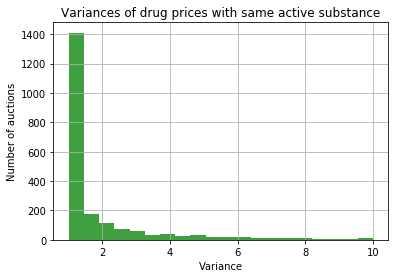

In [85]:
plt.hist(sorted(list(limited_variances.values())), 20, facecolor='g', alpha=0.75)
plt.xlabel('Variance')
# plt.xticks(np.arange(1, 10))
plt.title('Variances of drug prices with same active substance')
plt.ylabel('Number of auctions')
plt.grid(True)
plt.show()

In [86]:
len(limited_variances), len(med_dic)

(2089, 2682)

from 2 to 20

In [87]:
limited_variances = dict((k, v) for k, v in variances.items() if ((v >= 2) and (v < 10)))

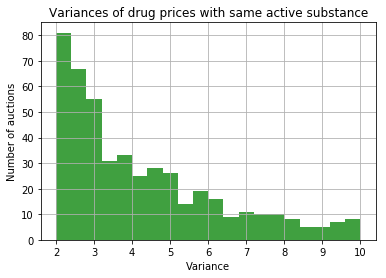

In [88]:
plt.hist(sorted(list(limited_variances.values())), 20, facecolor='g', alpha=0.75)
plt.xlabel('Variance')
# plt.xticks(np.arange(1, 10))
plt.title('Variances of drug prices with same active substance')
plt.ylabel('Number of auctions')
plt.grid(True)
plt.show()

In [89]:
len(limited_variances)

468

In [90]:
2089 - 468

1621

In [91]:
limited_variances

{'амоксициллин': 5.153814089203835,
 'азитромицин': 3.613220998055735,
 'абактал': 4.83837037037037,
 'кардикет': 4.850953527124607,
 'имован': 6.858,
 'магнев': 2.6897872467757864,
 'нобен': 2.8200000000000003,
 'тетурам': 2.283387622149837,
 'пирлиндол': 6.520833333333333,
 'тагиста': 3.2168619342981852,
 'трилептал': 7.711498547114985,
 'тореал': 6.719844986274827,
 'бромокриптин': 5.632040050062578,
 'конвулекстаблетки': 3.9408914043155288,
 'сирдалут': 2.14117053481332,
 'инстенон': 6.362324544142726,
 'беллатаминал': 3.8261401897765532,
 'эсмерон': 6.480245170971147,
 'винпотропил': 2.87569573283859,
 'ропивакаина': 2.491925716592652,
 'пропофола': 9.2503259452412,
 'ницерголин': 3.827214431682052,
 'наропин': 8.044864864864865,
 'лоперамид': 7.373134328358209,
 'тиогамма': 2.7249370669296447,
 'стугерон': 3.040078201368524,
 'пантокальцин': 5.134153922665671,
 'спазган': 7.968,
 'тремонорм': 5.074648819592557,
 'бетамакс': 5.28,
 'этосуксимид': 4.865715667311412,
 'баклофен': 6.

In [92]:
df[df['name_del_text'].str.contains(" амоксициллин ")].sort_values('price')

,_id,product_name,quantity,price,sum,name_norm,weight,number,name_word,type,name_del,name_del_text,len,name_del_first
5,12799474,Амоксициллин таб. 250мг №20,150.0,23.99,3598.50,амоксициллин таб мг,250.0,№20,"[амоксициллин, таб, мг]",tablet,[амоксициллин],амоксициллин мг,1,[амоксициллин]
22022,3763388_2,Амоксициллин таб. 250мг №20,150.0,23.99,3598.50,амоксициллин таб мг,250.0,№20,"[амоксициллин, таб, мг]",tablet,[амоксициллин],амоксициллин мг,1,[амоксициллин]
47964,4778291_2,Амоксициллин таб. 250мг №20,150.0,23.99,3598.50,амоксициллин таб мг,250.0,№20,"[амоксициллин, таб, мг]",tablet,[амоксициллин],амоксициллин мг,1,[амоксициллин]
94160,6202953_7,Амоксициллин таб. 250мг №10 \r\n,3.0,26.00,78.00,амоксициллин таб мг \r\n,250.0,№10,"[амоксициллин, таб, мг]",tablet,[амоксициллин],амоксициллин мг,1,[амоксициллин]
14931,24208065,Амоксициллин таб. 500мг №10 уп.конт.яч.пач.кар...,3.0,28.74,86.22,амоксициллин таб мг уп конт яч пач карт\r\n,500.0,№10,"[амоксициллин, таб, мг, уп, конт, яч, пач, карт]",tablet,"[амоксициллин, уп, конт, яч, пач, карт]",амоксициллин мг уп конт яч пач карт,6,"[амоксициллин, уп, конт, яч, пач, карт]"
65182,5383752_14,Амоксициллин/\r\nАмоксициллин\r\n,1000.0,31.69,31690.00,амоксициллин\r\nамоксициллин\r\n,0.0,,"[амоксициллин, амоксициллин]",unknown,"[амоксициллин, амоксициллин]",амоксициллин амоксициллин,2,"[амоксициллин, амоксициллин]"
104639,6594285_1,Амоксициллин\r\n\r\n,200.0,34.32,6864.00,амоксициллин\r\n\r\n,0.0,,[амоксициллин],unknown,[амоксициллин],амоксициллин,1,[амоксициллин]
50969,4924646_16,Амоксициллин,200.0,38.00,7600.00,амоксициллин,0.0,,[амоксициллин],unknown,[амоксициллин],амоксициллин,1,[амоксициллин]
47965,4778291_3,Амоксициллин таб. 500мг №20,150.0,44.29,6643.50,амоксициллин таб мг,500.0,№20,"[амоксициллин, таб, мг]",tablet,[амоксициллин],амоксициллин мг,1,[амоксициллин]
22023,3763388_3,Амоксициллин таб. 500мг №20,150.0,44.29,6643.50,амоксициллин таб мг,500.0,№20,"[амоксициллин, таб, мг]",tablet,[амоксициллин],амоксициллин мг,1,[амоксициллин]


### Recursive Levenshtein Function

In [93]:
def LD(s, t):
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1
       
    res = min([LD(s[:-1], t)+1,
               LD(s, t[:-1])+1, 
               LD(s[:-1], t[:-1]) + cost])
    return res
print(LD("Python", "Peithen"))

3


In [102]:
med_dic_list = list(med_dic['name'])
for i in range(len(med_dic_list) - 1):
    for j in range(i + 1, len(med_dic_list)):
        if (LD(med_dic_list[i], med_dic_list[j]) <= 2):
            print(med_dic_list[i], med_dic_list[j])
        print(i, j)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57


KeyboardInterrupt: 

In [ ]:
def LDshort(s, t):
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1
    first = LD(s[:-1], t) + 1
    second = LD(s, t[:-1]) + 1
    third = LD(s[:-1], t[:-1]) + cost
    if ((first > ))
    res = min(first, second, third)
    return res
print(LD("Python", "Peithen"))

In [104]:
med_dic_list[58]

'бромдигидрохлорфенилбензодиазепин'

### Highly Effective Levenstein Function

In [141]:
from functools import lru_cache

# def call_counter(func):
#     def helper(*args, **kwargs):
#         helper.calls += 1
#         return func(*args, **kwargs)
#     helper.calls = 0
#     helper.__name__= func.__name__
#     return helper
# def memoize(func):
#     mem = {}
#     def memoizer(*args, **kwargs):
#         key = str(args) + str(kwargs)
#         if key not in mem:
#             mem[key] = func(*args, **kwargs)
#         return mem[key]
#     return memoizer
@lru_cache(maxsize=128)
def levenshtein(s, t):
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1
    
    res = min([levenshtein(s[:-1], t)+1,
               levenshtein(s, t[:-1])+1, 
               levenshtein(s[:-1], t[:-1]) + cost])
    return res

print(levenshtein("Python", "Peithen"))
# print("The function was called " + str(levenshtein.calls) + " times!")

new_med_dic = set(list(med_dic['name']))
from collections import defaultdict
med_dic_typo = defaultdict(int)

med_dic_list = list(med_dic['name'])
for i in range(len(med_dic_list) - 1):
    for j in range(i + 1, len(med_dic_list)):
        if (levenshtein(med_dic_list[i], med_dic_list[j]) <= 1):
            med_dic_typo[med_dic_list[i]] += 1
            try:
                new_med_dic.remove(med_dic_list[j])
            except KeyError:
                pass 
    if not (i % 100):
        print(i)
        levenshtein.cache_clear()

3
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [137]:
@lru_cache(maxsize=32)
def get_pep(num):
    return num ** 2

for n in 8, 290, 308, 320, 8, 218, 320, 279, 289, 320, 9991:
    pep = get_pep(n)
    print(n, pep)

get_pep.cache_info()

8 64
290 84100
308 94864
320 102400
8 64
218 47524
320 102400
279 77841
289 83521
320 102400
9991 99820081


CacheInfo(hits=3, misses=8, maxsize=32, currsize=8)

In [139]:
med_dic_typo

defaultdict(int, {})

In [146]:
len(new_med_dic)

2141

In [147]:
len(med_dic)

2682

In [143]:
med_dic_typo

defaultdict(int,
            {'сульпирид': 3,
             'актовегин': 2,
             'корвалол': 1,
             'винпоцетин': 7,
             'аминазин': 7,
             'амитриптилин': 10,
             'мексидол': 3,
             'церетон': 7,
             'дроперидол': 4,
             'кавинтон': 1,
             'прозерин': 1,
             'фенорелаксан': 4,
             'фезипам': 3,
             'галоперидол': 5,
             'глиатилин': 1,
             'кеппра': 2,
             'ноотропил': 1,
             'пантогам': 1,
             'пикамилон': 2,
             'пирацетам': 12,
             'трифтазин': 1,
             'фезам': 1,
             'фенибут': 3,
             'глеацер': 1,
             'ингаляционного': 2,
             'феназепам': 8,
             'амисульприд': 1,
             'бромдигидрохлорфенилбензодиазепин': 7,
             'рисперидон': 1,
             'трифлуоперазин': 2,
             'хлорпромазин': 3,
             'хлорпротиксен': 5,
             'кордиа

In [145]:
sorted_typo = sorted(med_dic_typo.items(), key=lambda kv: -kv[1])
print(sorted_typo)

[('пирацетам', 12), ('амитриптилин', 10), ('феназепам', 8), ('церебролизин', 8), ('винпоцетин', 7), ('аминазин', 7), ('церетон', 7), ('бромдигидрохлорфенилбензодиазепин', 7), ('карбамазепин', 7), ('трамадол', 7), ('галоперидол', 5), ('хлорпротиксен', 5), ('бетагистин', 5), ('сонапакс', 5), ('цитофлавин', 5), ('мелипрамин', 5), ('реланиум', 5), ('финлепсин', 5), ('пентоксифиллин', 5), ('дроперидол', 4), ('фенорелаксан', 4), ('кордиамин', 4), ('фентанил', 4), ('амитриптиллин', 4), ('грандаксин', 4), ('мезапам', 4), ('листенон', 4), ('толперизон', 4), ('цераксон', 4), ('тригексифенидил', 4), ('азалептин', 4), ('сульпирид', 3), ('мексидол', 3), ('фезипам', 3), ('фенибут', 3), ('хлорпромазин', 3), ('неулептил', 3), ('сибазон', 3), ('сульфокамфокаин', 3), ('фенотропил', 3), ('циннаризин', 3), ('клофелин', 3), ('промедол', 3), ('наропин', 3), ('севоран', 3), ('афобазол', 3), ('кофеин', 3), ('димедрол', 3), ('топирамат', 3), ('карбамазепинакри', 3), ('клопиксолакуфаз', 3), ('актовегин', 2), ('

In [148]:
print("NUMBER OF TYPOS : ", len(med_dic) - len(new_med_dic))

NUMBER OF TYPOS :  541
